###Imports

In [1]:
!pip install flexBlock flexclash pytorch-lightning

In [3]:
import numpy as np
import torch
import copy
import tensorly as tl
import torchvision
from functools import partial
from flex.data import Dataset, FedDataDistribution, FedDatasetConfig
from flex.model import FlexModel
from flex.pool import FlexPool, collect_clients_weights, fed_avg, init_server_model
from flexBlock.pool import BlockchainPool, PoFLBlockchainPool, PoWBlockchainPool
from flexBlock.pool.primitives import collect_to_send_wrapper
from flexclash.data import data_poisoner
from flexclash.pool import multikrum, trimmed_mean
from PIL import Image
from flex.pool.aggregators import set_tensorly_backend
from flex.pool.decorators import (
    aggregate_weights,
    collect_clients_weights,
    deploy_server_model,
    set_aggregated_weights,
)
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18, MobileNet_V2_Weights, mobilenet_v2, EfficientNet_B0_Weights, efficientnet_b0
from tqdm import tqdm
from pytorch_lightning import seed_everything

###Datasets

In [4]:
N_CLIENTS = 20
N_POISONED = 4
LOCAL_EPOCHS = 1
N_ROUNDS = 15
DEFAULT_BOOSTING = float(N_CLIENTS) / float(N_POISONED)
NON_IID_RATE = 0.5
POISONING_RATE = 0.1

# ========== MODEL/DATASET CONFIG ==========
MODEL_NAME = "efficientnet"  # Options: "resnet18", "efficientnet", "mobilenet"
DATASET_NAME = "GTSRB"   # Options: "MNIST", "CIFAR10", "GTSRB"
TRIGGER = "wanet"  # Options: "square", "wanet"
AGG_FUNCTION = "krum"  # Options: "fed_avg", "krum"
# ==========================================

SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

seed_everything(SEED) # reproducibility

Seed set to 42


42

###Set dataset and model

In [ ]:
if MODEL_NAME == "resnet18":
     data_transforms = ResNet18_Weights.DEFAULT.transforms()
     LR = 0.00005

elif MODEL_NAME == "mobilenet":
     data_transforms = MobileNet_V2_Weights.DEFAULT.transforms()
     LR = 0.0001

elif MODEL_NAME == "efficientnet":
     data_transforms = EfficientNet_B0_Weights.DEFAULT.transforms()
     LR = 0.0001

else:
    raise ValueError(f"Unknown model {MODEL_NAME}")


if AGG_FUNCTION == "fed_avg":
    agg_function = fed_avg
elif AGG_FUNCTION == "krum":
    agg_function = partial(multikrum, f=4, m=10)   # We use multikrum with that protect up to f=4 malicious clients and selects m=10 clients for aggregation
    agg_function.__name__ = "krum"


if DATASET_NAME == "MNIST":
    NUM_CLASSES = 10

    DEFAULT_BOOSTING = DEFAULT_BOOSTING / 2

    train_data = datasets.MNIST(root=".", train=True, download=True, transform=None)
    test_data = datasets.MNIST(root=".", train=False, download=True, transform=None)

    data_transforms = transforms.Compose([
        transforms.Resize(224),  # ResNet18 expects 224x224 input; adjust as needed
        transforms.Lambda(lambda x: x.convert("RGB")),  # Convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means/stds, suitable for ResNet18
                             std=[0.229, 0.224, 0.225])
    ])


    POISON_PIXELS = 4

elif DATASET_NAME == "CIFAR10":
    NUM_CLASSES = 10
    train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=None)
    test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=None)

    POISON_PIXELS = 4

elif DATASET_NAME == "GTSRB":
    NUM_CLASSES = 43
    train_data = datasets.GTSRB(root=".", split="train", download=True, transform=None)
    test_data = datasets.GTSRB(root=".", split="test", download=True, transform=None)

    POISON_PIXELS = 12

else:
    raise ValueError("Unknown dataset")


test_data = Dataset.from_torchvision_dataset(test_data)

###Create data distribution

In [6]:
# Gets labels for all datasets
def get_labels(dataset):
    if hasattr(dataset, 'targets'):
        return np.array(dataset.targets)
    elif hasattr(dataset, '_labels'):
        return np.array(dataset._labels)
    elif hasattr(dataset, '_samples'):
        return np.array([label for _, label in dataset._samples])

DATA_LABELS = get_labels(train_data)

def dirichlet_distribution_split_per_client(dataset, n_clients, alpha=NON_IID_RATE):
    y = DATA_LABELS
    num_classes = len(np.unique(y))

    class_proportions = torch.distributions.Dirichlet(torch.tensor([alpha] * n_clients)).sample([num_classes]).numpy()

    split_indices = [[] for _ in range(n_clients)]

    # Split data by class
    for class_idx in range(num_classes):
        class_indices = np.where(y == class_idx)[0]
        np.random.shuffle(class_indices)

        class_sample_sizes = (class_proportions[class_idx] * len(class_indices)).astype(int)
        class_sample_sizes[-1] = len(class_indices) - np.sum(class_sample_sizes[:-1])

        start_idx = 0
        for client_idx, n_samples in enumerate(class_sample_sizes):
            split_indices[client_idx].extend(class_indices[start_idx:start_idx + n_samples].tolist())
            start_idx += n_samples

    #Shuffles local client data indices, otherwise all classes are separated in the datasets
    for client_indices in split_indices:
        np.random.shuffle(client_indices)

    return split_indices

# Creates a non-IID setup with dirichclet distribution
split_indices = dirichlet_distribution_split_per_client(train_data, N_CLIENTS)

config = FedDatasetConfig(seed=SEED)
config.replacement = False
config.n_nodes = N_CLIENTS
config.indexes_per_node = split_indices

flex_dataset = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

In [7]:
def print_all_clients_class_distribution():

    for client_id in flex_dataset:
        client_dataset = flex_dataset[client_id]

        labels = [label for _, label in client_dataset]
        unique, counts = np.unique(labels, return_counts=True)
        count_dict = {int(k): int(v) for k, v in zip(unique, counts)}

        print(f"Client {client_id} data: {count_dict}")
        print(f" - Total number of samples: {sum(count_dict.values())}")

print_all_clients_class_distribution()

Client 0 data: {0: 636, 1: 48, 2: 29, 3: 135, 4: 175, 5: 171, 6: 156, 7: 90, 8: 139, 9: 231}
 - Total number of samples: 1810
Client 1 data: {0: 127, 1: 14, 2: 10, 3: 331, 4: 776, 5: 166, 6: 370, 7: 87, 8: 7, 9: 15}
 - Total number of samples: 1903
Client 2 data: {0: 1, 1: 184, 2: 777, 3: 29, 4: 452, 5: 2, 6: 129, 8: 248, 9: 96}
 - Total number of samples: 1918
Client 3 data: {0: 285, 1: 240, 2: 65, 3: 98, 4: 470, 5: 359, 6: 38, 7: 2361, 8: 272, 9: 1132}
 - Total number of samples: 5320
Client 4 data: {0: 20, 1: 543, 2: 951, 3: 3177, 4: 8, 5: 182, 6: 140, 7: 108, 8: 223, 9: 2}
 - Total number of samples: 5354
Client 5 data: {0: 189, 1: 14, 2: 725, 3: 1, 4: 28, 5: 21, 6: 25, 7: 3, 9: 67}
 - Total number of samples: 1073
Client 6 data: {0: 47, 1: 7, 2: 47, 3: 44, 4: 677, 5: 420, 6: 1345, 7: 14, 8: 1232, 9: 128}
 - Total number of samples: 3961
Client 7 data: {0: 258, 1: 397, 2: 120, 3: 55, 4: 340, 5: 62, 6: 17, 7: 203, 8: 751, 9: 37}
 - Total number of samples: 2240
Client 8 data: {0: 21

###Poisoning

In [ ]:
target_label = 3

@data_poisoner
def poison_square(img, label, prob=POISONING_RATE):
    if np.random.random() > prob:
        return img, label

    arr = np.array(img)
    new_arr = copy.deepcopy(arr)

    if DATASET_NAME == "MNIST":
        new_arr[-1, -1] = 255
        new_arr[-2, -1] = 255
        new_arr[-1, -2] = 255
        new_arr[-2, -2] = 255

    else:
        new_arr[-POISON_PIXELS:, -POISON_PIXELS:, 0] = 255
        new_arr[-POISON_PIXELS:, -POISON_PIXELS:, 1:] = 0


    return Image.fromarray(new_arr), target_label



k = 16   # Grid resolution
s = 0.8  # Warping strength

# Generate fixed noise pattern grid (trigger)
control_points = torch.rand(k, k, 2) * 2 - 1
control_points = control_points / torch.mean(torch.abs(control_points))
control_points_reshaped = control_points.permute(2, 0, 1).unsqueeze(0)

noise_grid_base = control_points_reshaped 

@data_poisoner
def poison_wanet(img, label, prob=POISONING_RATE):
    if np.random.random() > prob:
        return img, label

    img_tensor = torchvision.transforms.functional.pil_to_tensor(img).float() / 255.0
    current_img_h, current_img_w = img_tensor.shape[1], img_tensor.shape[2]

    # Resize noise grid to current image size
    noise_grid = torch.nn.functional.interpolate(
        noise_grid_base,
        size=(current_img_h, current_img_w),
        mode='bicubic',
        align_corners=True
    ).squeeze(0).permute(1, 2, 0).unsqueeze(0)

    # Create identity grid and dynamic grid 
    x_coords = torch.linspace(-1, 1, current_img_w)
    y_coords = torch.linspace(-1, 1, current_img_h)
    grid_x, grid_y = torch.meshgrid(x_coords, y_coords, indexing='xy')
    identity_grid = torch.stack([grid_x, grid_y], dim=-1).unsqueeze(0)
    dynamic_grid = torch.clamp(identity_grid + s * noise_grid / current_img_h, -1, 1)

    # Apply warping
    poisoned_tensor = torch.nn.functional.grid_sample(
        img_tensor.unsqueeze(0), dynamic_grid, align_corners=True
    ).squeeze(0)

    poisoned_array = (poisoned_tensor * 255.0).clamp(0, 255).byte()
    if DATASET_NAME == "MNIST":
        poisoned_array = poisoned_array.squeeze(0).numpy()
    else:
        poisoned_array = poisoned_array.permute(1, 2, 0).numpy()

    poisoned_img = Image.fromarray(poisoned_array)

    return poisoned_img, target_label


if TRIGGER == "square":
    poison = poison_square
elif TRIGGER == "wanet":
    poison = poison_wanet
    

poisoned_clients_ids = list(range(N_POISONED))
flex_dataset = flex_dataset.apply(poison, node_ids=poisoned_clients_ids)

poisoned_test_data = poison(test_data, prob=1)

Clean sample:
Label: 18


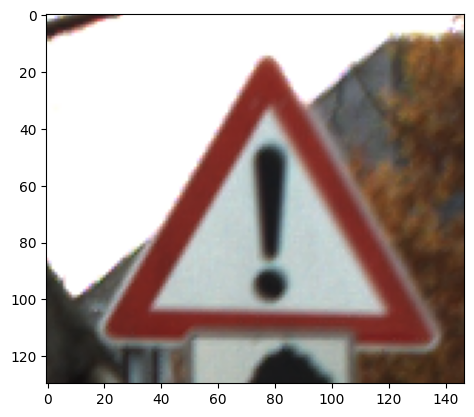

In [100]:
sample = 6
print(f"Clean sample:")
print(f"Label:", test_data[sample][1])
img = test_data[sample][0]
_ = plt.imshow(img)

Poisoned sample:
Label: 3


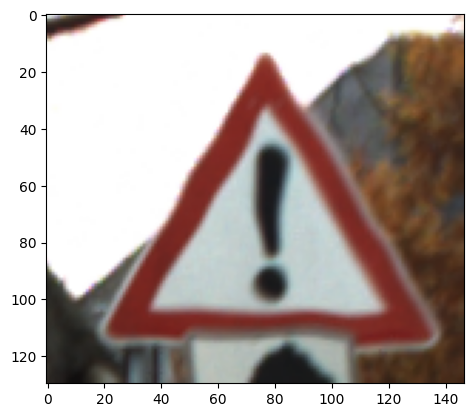

In [103]:
print(f"Poisoned sample:")
print(f"Label:", poisoned_test_data[sample][1])
img = poisoned_test_data[sample][0]
_ = plt.imshow(img)

###Rest of the code

In [ ]:
def get_model(num_classes=NUM_CLASSES, model_name=MODEL_NAME):

    if model_name == "resnet18":
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "mobilenet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet":
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    return model

@init_server_model
def build_server_model():
    global server_flex_model

    server_flex_model = FlexModel()

    server_flex_model["model"] = get_model()
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.functional.cross_entropy
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {"lr": LR}

    return server_flex_model


def train(client_flex_model: FlexModel, client_data: Dataset):
    train_dataset = client_data.to_torchvision_dataset(transform=data_transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=128)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(LOCAL_EPOCHS):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    server_dict = client_flex_model["server_model"].state_dict()
    dev = [weight_dict[name] for name in weight_dict][0].get_device()
    dev = "cpu" if dev == -1 else "cuda"
    return [
        (weight_dict[name] - server_dict[name].to(dev)).type(torch.float)
        for name in weight_dict
    ]


def apply_boosting(weight_list: list, coef: float):
    set_tensorly_backend(weight_list)

    n_layers = len(weight_list)
    weights = []
    for index_layer in range(n_layers):
        context = tl.context(weight_list[index_layer])
        w = weight_list[index_layer] * tl.tensor(coef, **context)
        weights.append(w)
    return weights

@collect_clients_weights
def get_poisoned_weights(client_flex_model: FlexModel, boosting=None):
    boosting_coef = (
        boosting[client_flex_model.actor_id]
        if boosting is not None
        else DEFAULT_BOOSTING
    )
    weight_dict = client_flex_model["model"].state_dict()
    server_dict = client_flex_model["server_model"].state_dict()
    dev = [weight_dict[name] for name in weight_dict][0].get_device()
    dev = "cpu" if dev == -1 else "cuda"
    return apply_boosting(
        [
            (weight_dict[name] - server_dict[name].to(dev)).type(torch.float)
            for name in weight_dict
        ],
        boosting_coef,
    )


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    new_flex_model = FlexModel()
    new_flex_model["model"] = copy.deepcopy(server_flex_model["model"])
    new_flex_model["server_model"] = copy.deepcopy(server_flex_model["model"])
    new_flex_model["criterion"] = copy.deepcopy(server_flex_model["criterion"])
    new_flex_model["optimizer_func"] = copy.deepcopy(
        server_flex_model["optimizer_func"]
    )
    new_flex_model["optimizer_kwargs"] = copy.deepcopy(
        server_flex_model["optimizer_kwargs"]
    )
    return new_flex_model


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    dev = aggregated_weights[0].get_device()
    dev = "cpu" if dev == -1 else "cuda"
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(weight_dict[layer_key].to(dev) + new)


def clean_up_models(clients: FlexPool):
    import gc

    clients.clients.map(lambda model, _: model.clear())
    gc.collect()
    torch.cuda.empty_cache()



def obtain_metrics(server_flex_model: FlexModel, data: Dataset):
    if data is None:
        data = test_data
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = data.to_torchvision_dataset(transform=data_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc


def obtain_backdoor_metrics(server_flex_model: FlexModel, _):
    return obtain_metrics(server_flex_model, poisoned_test_data)


def obtain_eval_metrics(server_flex_model: FlexModel, _):
    return obtain_metrics(server_flex_model, test_data)


def train_base(pool: FlexPool, n_rounds=N_ROUNDS):

    poisoned_clients = pool.clients.select(
        lambda client_id, _: client_id in poisoned_clients_ids
    )
    clean_clients = pool.clients.select(
        lambda client_id, _: client_id not in poisoned_clients_ids
    )

    print("\n" + "="*40)
    print("               WARMING UP")
    print("="*40)

    #Just 2 epochs on benign clients to warm up the model
    for i in tqdm(range(3), "WARMUP"):
        pool.servers.map(copy_server_model_to_clients, clean_clients)

        clean_clients.map(train)

        pool.aggregators.map(get_clients_weights, clean_clients)
        pool.aggregators.map(agg_function)
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        clean_up_models(clean_clients)

    acc = pool.servers.map(obtain_eval_metrics)
    loss, accuracy = acc[0]
    print(acc)
    print("Warmup Accuracy:")
    print(f"  - Loss     : {loss:.4f}")
    print(f"  - Accuracy : {accuracy * 100:.2f}%")

    print("\n" + "="*40)
    print(f"            TRAINING ROUNDS")
    print("="*40)
    for i in tqdm(range(n_rounds), "ROUNDS OF TRAINING"):

        pool.servers.map(copy_server_model_to_clients, clean_clients)
        pool.servers.map(copy_server_model_to_clients, poisoned_clients)

        clean_clients.map(train)
        poisoned_clients.map(train)

        pool.aggregators.map(get_clients_weights, clean_clients)
        pool.aggregators.map(get_poisoned_weights, poisoned_clients)

        pool.aggregators.map(agg_function)
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        clean_up_models(clean_clients)
        clean_up_models(poisoned_clients)

        round_metrics = pool.servers.map(obtain_metrics)
        backdoor_round_metrics = pool.servers.map(obtain_backdoor_metrics)

        for loss, acc in round_metrics:
            print(f"Clean Data   :  Loss: {loss:.4f} | Acc: {acc * 100:.2f}%")

        for bd_loss, bd_accuracy in backdoor_round_metrics:
            print(f"Backdoor Data:  Loss: {bd_loss:.4f} | Acc: {bd_accuracy * 100:.2f}%")


    acc = pool.servers.map(obtain_eval_metrics)
    backdoor_acc = pool.servers.map(obtain_backdoor_metrics)

    return acc, backdoor_acc


In [5]:
print(f"***Client-Server (Single Pool) Experiment***")
print(f"  Model   : {MODEL_NAME}")
print(f"  Dataset : {DATASET_NAME}")
print(f"  Non-IID : {NON_IID_RATE}")
print(f"  Trigger : {TRIGGER}")
print(f"  Aggregation: {AGG_FUNCTION}")

pool = FlexPool.client_server_pool(flex_dataset, build_server_model)
metrics, backdoor_metrics = train_base(pool)


loss, accuracy = metrics[0]
bd_loss, bd_accuracy = backdoor_metrics[0]

print(f"{'='*30}")
print(f" *** Final Model Metrics ***")


print("Clean Data:")
print(f"  - Loss     : {loss:.4f}")
print(f"  - Accuracy : {accuracy * 100:.2f}%")

print("Backdoor Data:")
print(f"  - Loss     : {bd_loss:.4f}")
print(f"  - Accuracy : {bd_accuracy * 100:.2f}%")

print(f"{'='*30}")

***Client-Server (Single Pool) Experiment***
  Model   : efficientnet
  Dataset : GTSRB
  Non-IID : 0.5
  Trigger : wanet
  Aggregation: krum


NameError: name 'flex_dataset' is not defined